# CA2 Face Recognition                                                                        
# Name：Dong Xinyue ID：E1124282
# Question3: GMM

In [38]:
import os
import matplotlib.pyplot as plt
from PIL import Image

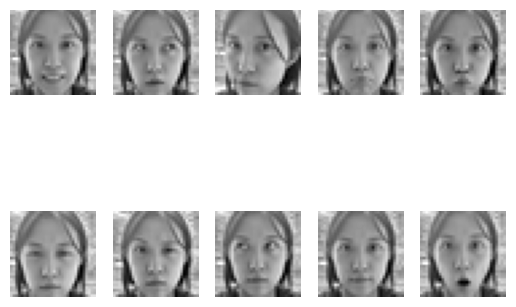

In [39]:
source_dir = os.path.join('PIE', 'my_orgimage')
target_dir = os.path.join('PIE', '69')
if not os.path.exists(target_dir):
    os.mkdir(target_dir)

image_paths = sorted([f for f in os.listdir(source_dir) if f.endswith('.jpg')])
num_rows = 2
num_columns = 5

def process_image(img_path, source_dir, target_dir):
    img = Image.open(os.path.join(source_dir, img_path)).convert('L')
    width, height = img.size
    img = img.crop((width // 8, height // 8, 7 * width // 8, 7 * height // 8)).resize((32, 32), Image.LANCZOS)
    return img

for i, img_path in enumerate(image_paths):
    img = process_image(img_path, source_dir, target_dir)
    plt.subplot(num_rows, num_columns, i % (num_rows * num_columns) + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    if not os.path.exists(os.path.join(target_dir, img_path)):
        img.save(os.path.join(target_dir, img_path))
plt.show()

### Whole Dataset

In [40]:
import random
import numpy as np
from sklearn.model_selection import train_test_split

In [41]:
random.seed(77)
subjects = [69] + random.sample(range(1, 69), 25)
print('26 subject numbers:', subjects)

n_imgs_subj = [len([f for f in os.listdir(os.path.join('PIE', str(s))) if f.endswith('.jpg')]) for s in subjects]
n_imgs = sum(n_imgs_subj) 
print('number of images per subject: {}'.format(n_imgs_subj))

X = np.empty((n_imgs, 32, 32))
y = np.empty((n_imgs, 1))

for si, s in enumerate(subjects):
    for i, img_path in enumerate([f for f in os.listdir(os.path.join('PIE', str(s))) if f.endswith('.jpg')]):
        img_path = os.path.join('PIE', str(s), str(i+1)+'.jpg')
        X[sum(n_imgs_subj[:si]) + i, :, :] = np.array(Image.open(img_path))
        y[sum(n_imgs_subj[:si]) + i] = s
print('X or dataset shape: {}\ny or label shape: {}'.format(X.shape, y.shape))

# Split the data into CMUPIE and selfie subsets
X_CMUPIE = X[y.flatten() != 69]
y_CMUPIE = y[y != 69]
X_selfies = X[y.flatten() == 69]
y_selfies = y[y == 69]
X_train_CMUPIE, X_test_CMUPIE, y_train_CMUPIE, y_test_CMUPIE = train_test_split(
    X_CMUPIE, y_CMUPIE, test_size=0.3, random_state=77)
X_train_selfies, X_test_selfies, y_train_selfies, y_test_selfies = train_test_split(
    X_selfies, y_selfies, test_size=0.3, random_state=77)
X_train = np.concatenate([X_train_CMUPIE, X_train_selfies], axis=0)
y_train = np.concatenate([y_train_CMUPIE, y_train_selfies], axis=0)
X_test = np.concatenate([X_test_CMUPIE, X_test_selfies], axis=0)
y_test = np.concatenate([y_test_CMUPIE, y_test_selfies], axis=0)
print('The number of images in train set: {}\nThe number of images in in test set: {}'.format(y_train.shape[0], y_test.shape[0]))

26 subject numbers: [69, 33, 42, 26, 31, 25, 53, 61, 8, 19, 65, 36, 40, 16, 10, 58, 41, 43, 68, 1, 18, 2, 32, 12, 13, 51]
number of images per subject: [10, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170]
X or dataset shape: (4260, 32, 32)
y or label shape: (4260, 1)
The number of images in train set: 2982
The number of images in in test set: 1278


Number of Components: raw


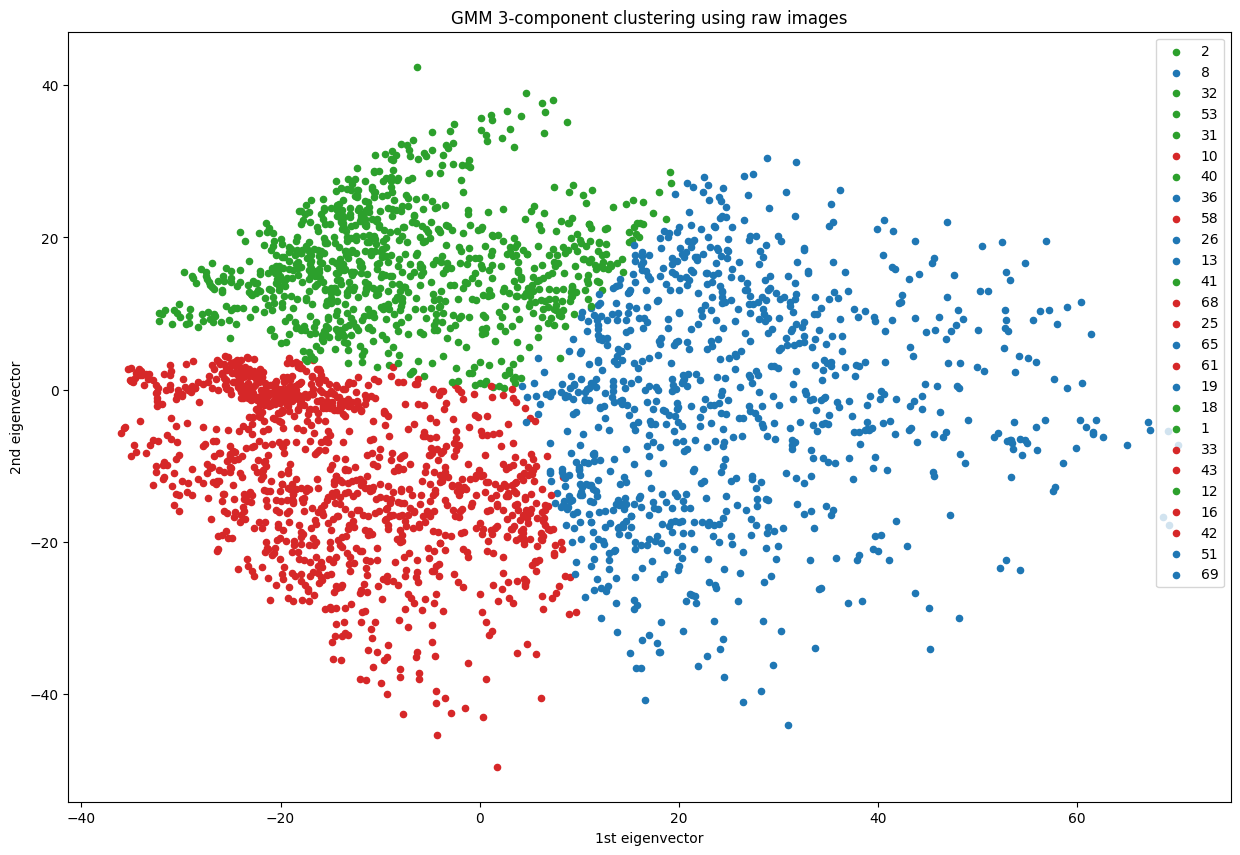

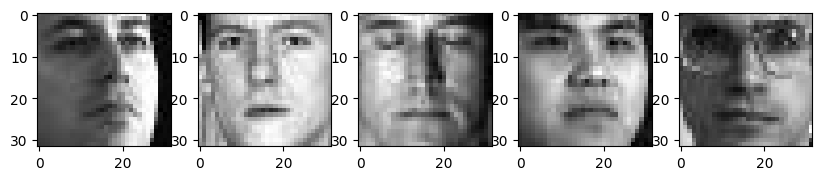

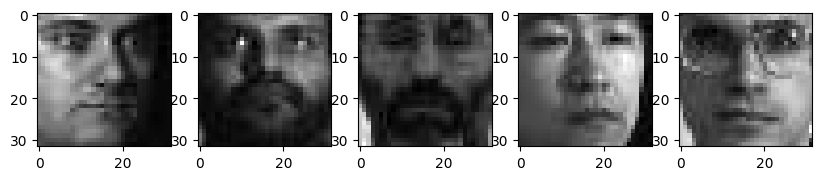

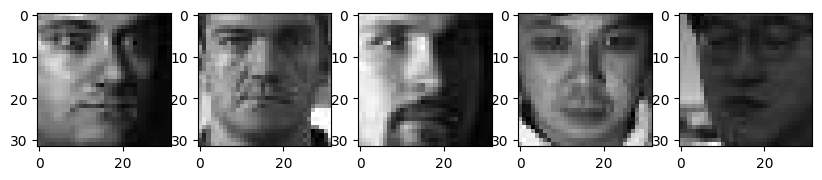

Number of Components: 80


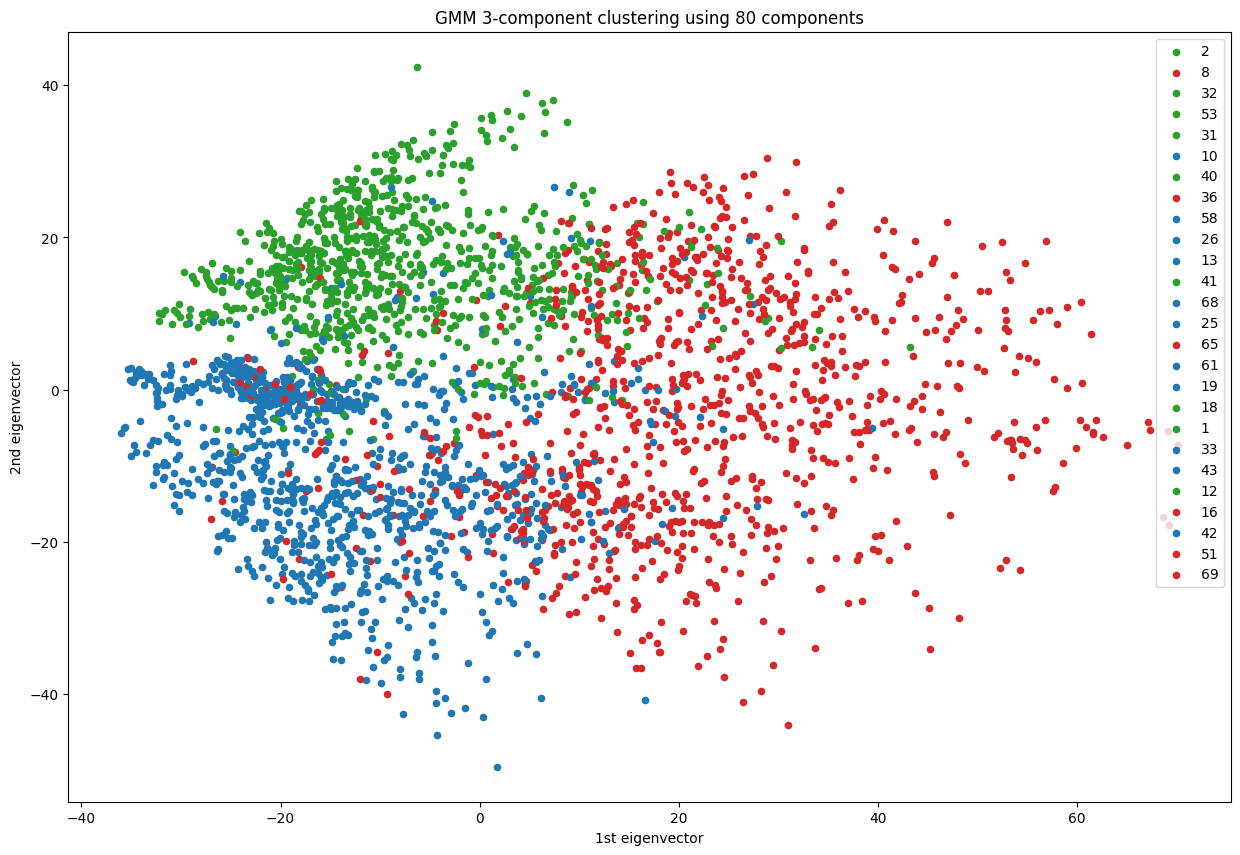

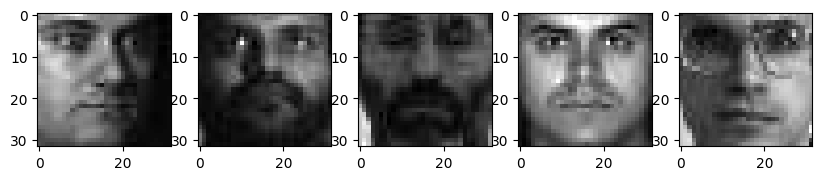

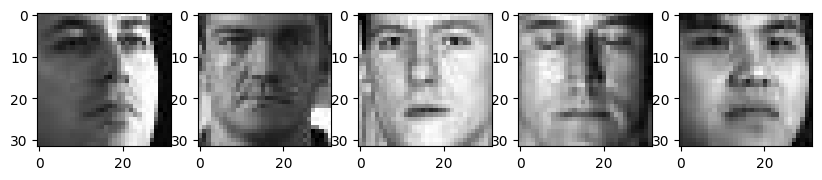

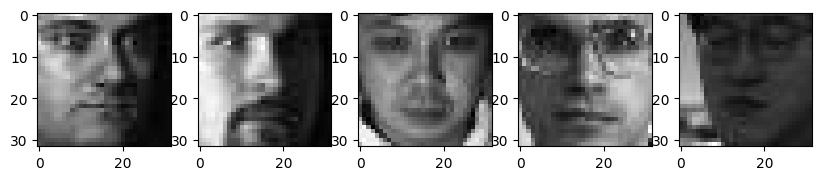

Number of Components: 200


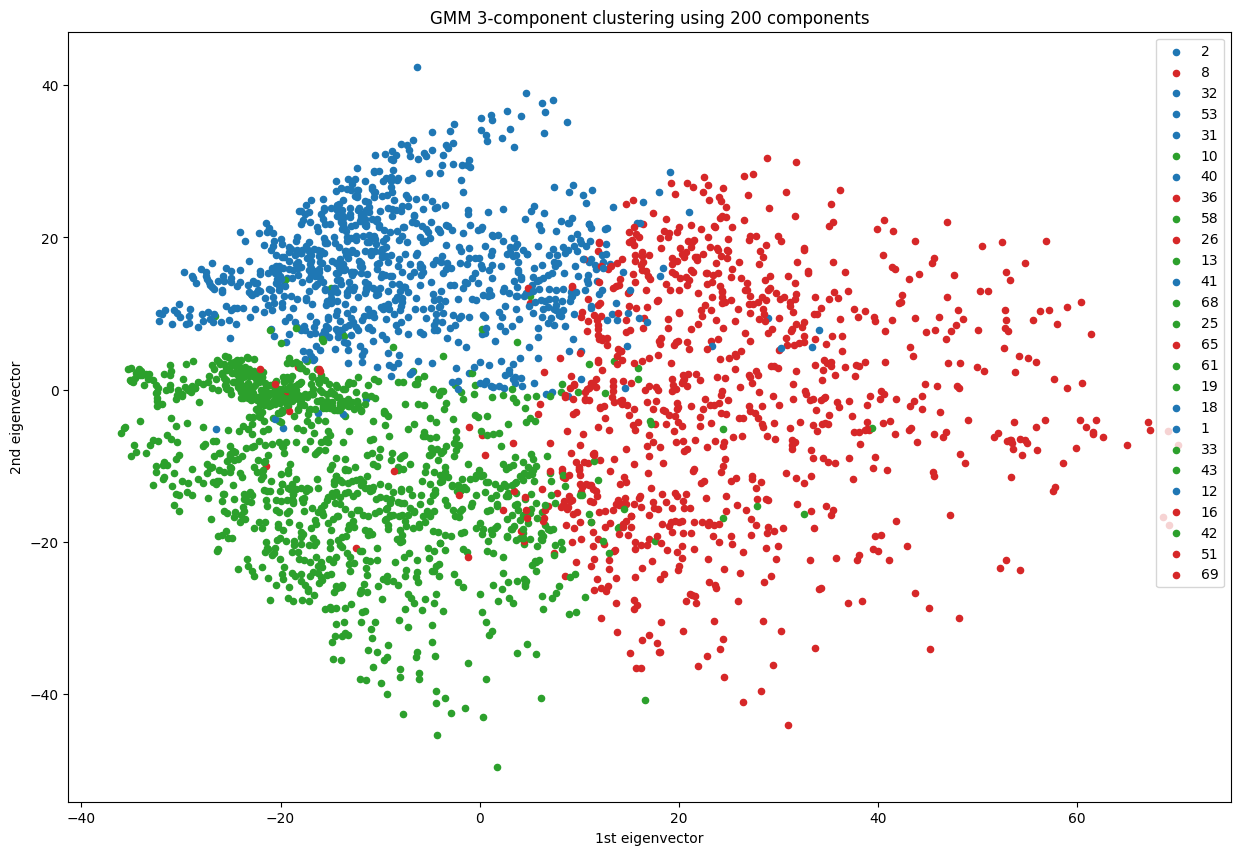

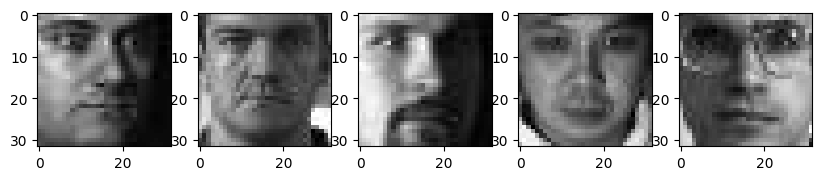

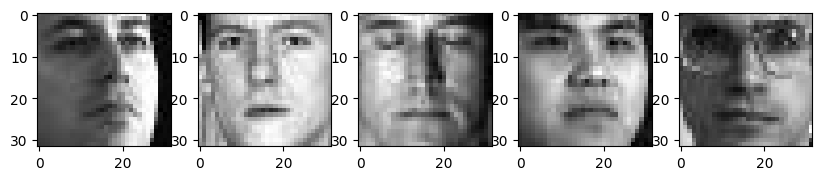

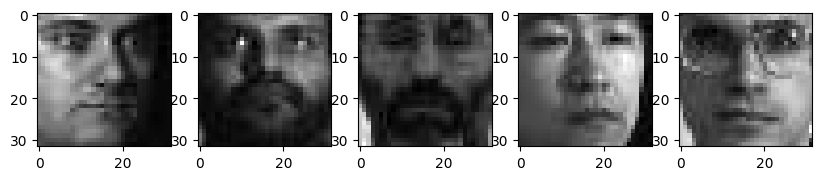

In [42]:
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import multivariate_normal

class PCA:
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.components_ = None
        self.explained_variance_ratio_ = None
        self.scaler = StandardScaler()

    def fit(self, X):
        X_normalized = self.scaler.fit_transform(X.reshape(X.shape[0], -1))
        X_corr = np.cov(X_normalized, rowvar=False)
        u, s, v = np.linalg.svd(X_corr)
        for i in range(u.shape[1]):
            if u[0, i] < 0:
                u[:, i] = -u[:, i]

        self.components_ = u[:, :self.n_components]
        self.explained_variance_ratio_ = s / np.sum(s)

    def transform(self, X):
        X_normalized = self.scaler.transform(X.reshape(X.shape[0], -1))
        return X_normalized.dot(self.components_)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    
class GaussMixture:
    def __init__(self, n_components=3, max_iter=100, tol=1e-4):
        self.n_components = ncomponents
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X):
        n_samples, n_features = X.shape
        self.weights = np.ones(self.n_components) / self.n_components
        self.means = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances = [np.cov(X.T)] * self.n_components

        for iteration in range(self.max_iter):
            responsibilities = self.calculate_responsibilities(X)
            self.update_parameters(X, responsibilities)
            log_likelihood = self.calculate_log_likelihood(X)
            if iteration > 0 and np.abs(log_likelihood - prev_log_likelihood) < self.tol:
                break
            prev_log_likelihood = log_likelihood

    def calculate_responsibilities(self, X):
        responsibilities = np.zeros((X.shape[0], self.n_components))

        for i in range(self.n_components):
            responsibilities[:, i] = self.weights[i] * multivariate_normal.pdf(X, self.means[i], self.covariances[i])
        normalization = responsibilities.sum(axis=1)[:, np.newaxis]
        responsibilities /= normalization
        return responsibilities

    def update_parameters(self, X, responsibilities):
        for i in range(self.n_components):
            Nk = responsibilities[:, i].sum()
            self.weights[i] = Nk / X.shape[0]
            self.means[i] = (X * responsibilities[:, i][:, np.newaxis]).sum(axis=0) / Nk
            self.covariances[i] = np.cov(X.T, aweights=responsibilities[:, i], bias=True)

    def calculate_log_likelihood(self, X):
        log_likelihood = 0
        for i in range(self.n_components):
            log_likelihood += self.weights[i] * multivariate_normal.logpdf(X, self.means[i], self.covariances[i])

        return log_likelihood

    def predict(self, X):
        responsibilities = self.calculate_responsibilities(X)
        return np.argmax(responsibilities, axis=1)

X_train_vec = X_train.reshape(X_train.shape[0], -1)
X_test_vec = X_test.reshape(X_test.shape[0], -1)
X_train_norm = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_norm = scaler.transform(X_test.reshape(X_test.shape[0], -1))
reduced_datasets = {"raw": [X_train_vec, X_test_vec]}

for ncomp in [80, 200]:
    pca_ncomp = PCA(n_components=ncomp)
    reduced_datasets[ncomp] = [
        pca_ncomp.fit_transform(X_train_norm),
        pca_ncomp.transform(X_test_norm)
    ]
from sklearn.mixture import GaussianMixture
for ncomp, item in reduced_datasets.items():
    print(f"Number of Components: {ncomp}")
    x_train, x_test = item
    clf = GaussianMixture(n_components=3)
    y_preds = clf.fit_predict(x_train)

    if ncomp == 'raw':
        x_train, x_test = reduced_datasets[80]

    colors = {0: 'tab:blue', 1: 'tab:red', 2: 'tab:green'}

    plt.figure(figsize=(15, 10))
    for i in range(x_train.shape[0]):
        plt.scatter(x_train[i, 0], x_train[i, 1], c=colors[y_preds[i]],
                    marker=None, s=20, label=int(y_train[i]))

    plt.xlabel('1st eigenvector')
    plt.ylabel('2nd eigenvector')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    if ncomp == 'raw':
        plt.title("GMM 3-component clustering using raw images")
    else:
        plt.title(f"GMM 3-component clustering using {ncomp} components")
    plt.show()

    for gmcomp in [0, 1, 2]:
        ygmcomp = Counter(y_train[np.where(y_preds == gmcomp)[0]])
        ygmcomp_main = list(ygmcomp.keys())[:5]

        f, axarr = plt.subplots(1, 5, figsize=(10, 6))
        for j in range(5):
            axarr[j].imshow(X_train[y_train == int(ygmcomp_main[j])][0], cmap='gray')
        plt.show()